## Table 13-Number of temporary foreign worker (TFW) positions on positive Labour Market Impact Assessments (LMIAs) by stream and province/territory between 2018Q1 and 2019Q4  
www.edsc-esdc.gc.ca/ouvert-open/bca-seb/imt-lmi/TFWP2019_Q4_Table_13_e.csv  

In [1]:
import pandas as pd
from pathlib import Path

In [2]:
datapath = Path(".//data")
#[x for x in datapath.iterdir() if x.is_file()]

In [3]:
d = pd.read_csv(datapath.joinpath("TFWP2019_Q4_Table_13_e.csv"))

In [5]:
# Column labels
YR = []
for h in d.iloc[0,:8].values:
    if str(h).isdigit():
        for i in range(4):
            YR.append(int(h))

TM = d.loc[1][1:9].values
YR = YR[:len(TM)]

col_labels = [(str(t) + "_" + str(y)).replace('Total_','').replace('nan_', '').replace(' ','_') for t, y in zip(TM,YR)]
col_labels

['Jan-Mar_2018',
 'Apr-Jun_2018',
 'Jul-Sep_2018',
 'Oct-Dec_2018',
 'Jan-Mar_2019',
 'Apr-Jun_2019',
 'Jul-Sep_2019',
 'Oct-Dec_2019']

In [6]:
# Row Indexs
streams = [
    'Filler',
    'Filler',
    'High-Wage',
    'Low-Wage',
    'Primary Agriculture',
    'Global Talent',
    'Unspecified',
    'Total'
]

geos = [
    'Canada',
    'Newfoundland and Labrador',
    'Prince Edward Island',
    'Nova Scotia',
    'New Brunswick',
    'Quebec',
    'Ontario',
    'Manitoba',
    'Saskatchewan',
    'Alberta',
    'British Columbia',
    'Yukon',
    'Northwest Territories',
    'Nunavut'
]

rowindex1 = []
rowindex2 = []

for g in geos:
    for s in streams:
        rowindex1.append(s)
        rowindex2.append(g)

In [7]:
# Content
df = d.iloc[:len(rowindex1),1:len(col_labels)+1]
df.columns = col_labels
df = df.apply(lambda x: x.str.replace('[,]', ''), axis=1)
df['geo'] = rowindex2
df['stream'] = rowindex1
df = df.set_index(['geo','stream']).apply(pd.to_numeric, errors='coerce').fillna(0).reset_index()
df = df[df.stream != "Filler"]
df.tail(5)

,geo,stream,Jan-Mar_2018,Apr-Jun_2018,Jul-Sep_2018,Oct-Dec_2018,Jan-Mar_2019,Apr-Jun_2019,Jul-Sep_2019,Oct-Dec_2019
107,Nunavut,Low-Wage,5.0,43.0,31.0,4.0,1.0,21.0,78.0,4.0
108,Nunavut,Primary Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,Nunavut,Global Talent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110,Nunavut,Unspecified,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,Nunavut,Total,5.0,58.0,63.0,6.0,1.0,44.0,84.0,4.0


In [8]:
import re
# reshape
df_poscnt = df.melt(id_vars=["geo","stream"], 
        var_name="duration", 
        value_name="pos_cnt")

df_poscnt

# duration to month start, month end, year
YR = []
month_start = []
month_end = []

for d in df_poscnt.duration:
    s = re.split('-|_',d)
    YR.append(s[2])
    month_start.append(s[0])
    month_end.append(s[1])

df_poscnt['YR'] = YR
df_poscnt['month_start'] = month_start
df_poscnt['month_end'] = month_end
df_poscnt = df_poscnt.set_index(['geo','stream','YR','month_start','month_end']).reset_index()
df_poscnt.head()

,geo,stream,YR,month_start,month_end,duration,pos_cnt
0,Canada,High-Wage,2018,Jan,Mar,Jan-Mar_2018,3051.0
1,Canada,Low-Wage,2018,Jan,Mar,Jan-Mar_2018,5071.0
2,Canada,Primary Agriculture,2018,Jan,Mar,Jan-Mar_2018,20458.0
3,Canada,Global Talent,2018,Jan,Mar,Jan-Mar_2018,544.0
4,Canada,Unspecified,2018,Jan,Mar,Jan-Mar_2018,1.0


### Canada  

In [10]:
df_canada = df_poscnt[(df_poscnt.geo.isin(['Canada']))]
df_canada_cnt = df_canada[['stream','YR','month_end','pos_cnt']].groupby(['stream','YR','month_end']).sum()
df_canada_cnt.reset_index(inplace=True)
combined =  "15 " + df_canada_cnt.month_end + " " + df_canada_cnt.YR.astype(str)
df_canada_cnt['time'] = pd.to_datetime(combined, format ='%d %b %Y')
df_canada_cnt = df_canada_cnt[['stream', 'time', 'pos_cnt']]
df_canada_cnt.set_index("time", inplace=True)
df_canada_cnt.stream.unique()

array(['Global Talent', 'High-Wage', 'Low-Wage', 'Primary Agriculture',
       'Total', 'Unspecified'], dtype=object)

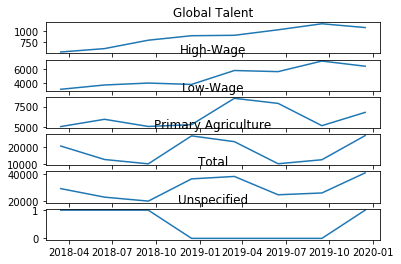

In [12]:
import matplotlib.pyplot as plt
df = df_canada_cnt
grouped = df.groupby('stream')
nrows = grouped.ngroups
fig, axs = plt.subplots(nrows = nrows, ncols = 1, sharex = True)

targets = zip(grouped.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
    ax.plot(grouped.get_group(key).sort_values(by=['time'])['pos_cnt'])
    ax.set_title(str(key))
plt.show()